In [1]:
# === Imports ===
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load benchmark file ===
with open(Path("../gpt_clm_vs_nl.json"), "r") as f:
    data = json.load(f)

# === Flatten JSON into a DataFrame ===
rows = []
for model, modes in data.items():
    for mode, records in modes.items():
        for r in records:
            rows.append(
                {
                    "model": model,
                    "mode": mode.upper(),
                    "transcript_index": r.get("transcript_index"),
                    "latency_ms": r.get("latency", 0) * 1000,
                    "input_tokens": r.get("input_tokens", 0),
                    "output_tokens": r.get("output_tokens", 0),
                    "total_tokens": r.get("total_tokens", 0),
                    "cost_usd": r.get("cost_usd", 0),
                }
            )

df = pd.DataFrame(rows)
df.head()

,model,mode,transcript_index,latency_ms,input_tokens,output_tokens,total_tokens,cost_usd
0,gpt-4-turbo,CLM,0,5750.737190,1030,173,1203,0.01549
1,gpt-4-turbo,CLM,1,5015.544176,975,154,1129,0.01437
2,gpt-4-turbo,CLM,2,4879.751921,951,151,1102,0.01404
3,gpt-4-turbo,CLM,3,4697.536230,990,150,1140,0.01440
4,gpt-4-turbo,CLM,4,3995.398998,996,158,1154,0.01470


In [2]:
# === Aggregate per model and mode ===
summary_df = (
    df.groupby(["model", "mode"])
    .agg(
        {
            "latency_ms": ["mean", "std"],
            "total_tokens": ["mean", "sum"],
            "cost_usd": ["mean", "sum"],
        }
    )
    .round(4)
)

summary_df

latency_ms            total_tokens        cost_usd  \
                               mean        std         mean    sum     mean   
model               mode                                                      
gpt-3.5-turbo       CLM   2585.8748   805.8345       1150.3  11503   0.0007   
                    NL    2495.0229   539.6461       2640.7  26407   0.0015   
gpt-4-turbo         CLM   5305.3544  1476.7465       1152.2  11522   0.0147   
                    NL    6593.8244  1228.6202       2666.7  26667   0.0309   
gpt-4-turbo-preview CLM   5274.9443  1410.0564       1158.7  11587   0.0149   
                    NL    6662.4526  1468.6213       2666.3  26663   0.0309   

                                  
                             sum  
model               mode          
gpt-3.5-turbo       CLM   0.0073  
                    NL    0.0151  
gpt-4-turbo         CLM   0.1472  
                    NL    0.3088  
gpt-4-turbo-preview CLM   0.1492  
                    NL    0.3087

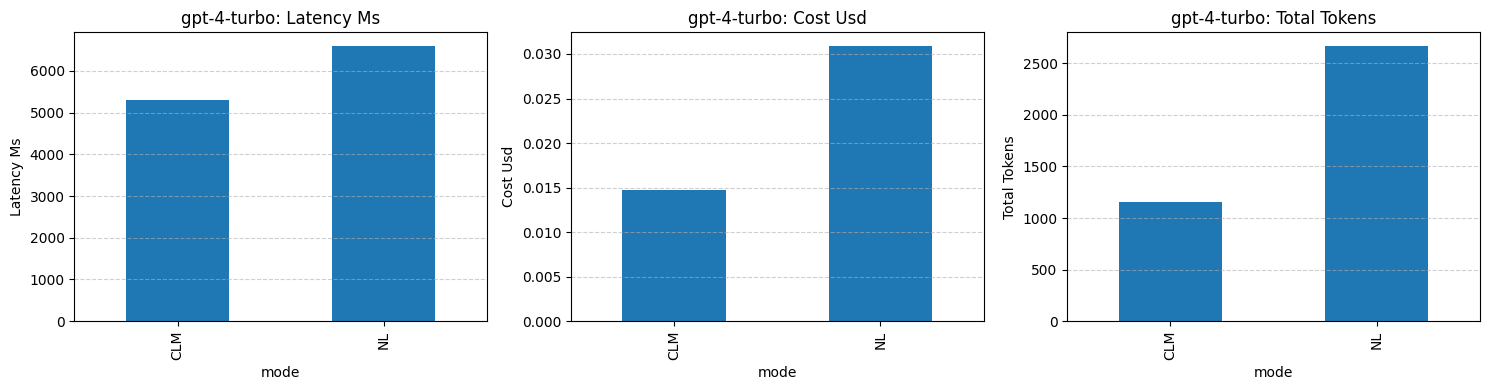

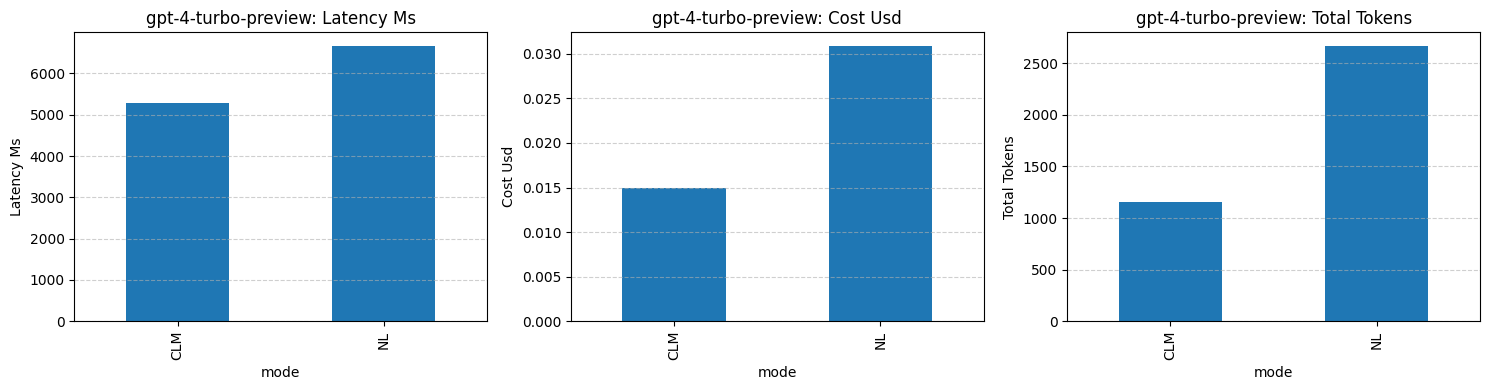

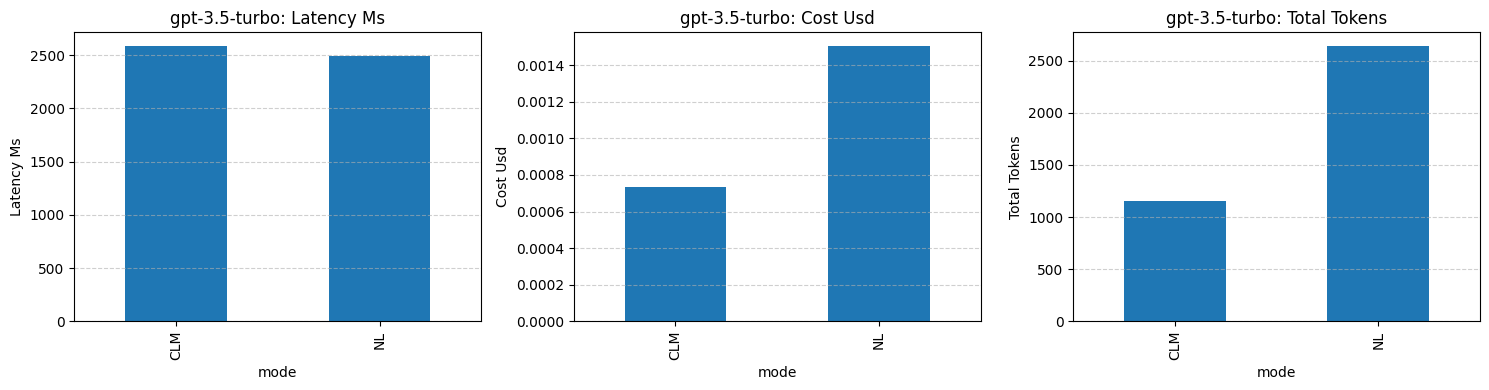

In [3]:
# === Plot setup ===
plot_metrics = ["latency_ms", "cost_usd", "total_tokens"]
models = df["model"].unique()

for model in models:
    subset = df[df["model"] == model]
    fig, axes = plt.subplots(1, len(plot_metrics), figsize=(5 * len(plot_metrics), 4))

    for i, metric in enumerate(plot_metrics):
        subset.groupby("mode")[metric].mean().plot(
            kind="bar", ax=axes[i], title=f"{model}: {metric.replace('_', ' ').title()}"
        )
        axes[i].set_ylabel(metric.replace("_", " ").title())
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

In [4]:
# === Pivot CLM vs NL comparison per transcript ===
pivot_df = df.pivot_table(
    index=["model", "transcript_index"],
    columns="mode",
    values=["latency_ms", "cost_usd", "total_tokens"],
)

# Flatten columns
pivot_df.columns = ["_".join(col).lower() for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

# === Calculate percentage differences ===
pivot_df["latency_diff_%"] = (
    (pivot_df["latency_ms_NL".lower()] - pivot_df["latency_ms_CLM".lower()])
    / pivot_df["latency_ms_CLM".lower()]
    * 100
)
pivot_df["cost_diff_%"] = (
    (pivot_df["cost_usd_NL".lower()] - pivot_df["cost_usd_CLM".lower()])
    / pivot_df["cost_usd_CLM".lower()]
    * 100
)
pivot_df["token_diff_%"] = (
    (pivot_df["total_tokens_NL".lower()] - pivot_df["total_tokens_CLM".lower()])
    / pivot_df["total_tokens_CLM".lower()]
    * 100
)

pivot_df.round(2)

,model,transcript_index,cost_usd_clm,cost_usd_nl,latency_ms_clm,latency_ms_nl,total_tokens_clm,total_tokens_nl,latency_diff_%,cost_diff_%,token_diff_%
0,gpt-3.5-turbo,0,0.00,0.00,2165.55,2257.98,1197.0,2619.0,4.27,93.79,118.80
1,gpt-3.5-turbo,1,0.00,0.00,4282.97,2366.43,1118.0,2627.0,-44.75,111.61,134.97
2,gpt-3.5-turbo,2,0.00,0.00,3395.31,2678.56,1105.0,2614.0,-21.11,110.05,136.56
3,gpt-3.5-turbo,3,0.00,0.00,2480.46,2314.11,1153.0,2653.0,-6.71,105.21,130.10
4,gpt-3.5-turbo,4,0.00,0.00,1708.44,1760.64,1133.0,2738.0,3.06,120.75,141.66
5,gpt-3.5-turbo,5,0.00,0.00,2209.85,1746.97,1170.0,2626.0,-20.95,96.84,124.44
6,gpt-3.5-turbo,6,0.00,0.00,2157.24,2433.11,1165.0,2634.0,12.79,99.33,126.09
7,gpt-3.5-turbo,7,0.00,0.00,1904.24,2966.74,1190.0,2632.0,55.80,100.00,121.18
8,gpt-3.5-turbo,8,0.00,0.00,2283.25,3463.86,1137.0,2621.0,51.71,110.29,130.52
9,gpt-3.5-turbo,9,0.00,0.00,3271.44,2961.85,1135.0,2643.0,-9.46,107.23,132.86


In [5]:
avg_diff = (
    pivot_df.groupby("model")[["latency_diff_%", "cost_diff_%", "token_diff_%"]]
    .mean()
    .round(2)
)

avg_diff

,latency_diff_%,cost_diff_%,token_diff_%
model,,,
gpt-3.5-turbo,2.46,105.51,129.72
gpt-4-turbo,28.60,110.07,131.61
gpt-4-turbo-preview,32.03,107.01,130.17


In [6]:
# Which approach is faster/cheaper overall per model?
comparison = []

for model in models:
    mdata = avg_diff.loc[model]
    faster = "CLM" if mdata["latency_diff_%"] > 0 else "NL"
    cheaper = "CLM" if mdata["cost_diff_%"] > 0 else "NL"
    comparison.append(
        {"model": model, "faster_model": faster, "cheaper_model": cheaper}
    )

pd.DataFrame(comparison)

,model,faster_model,cheaper_model
0,gpt-4-turbo,CLM,CLM
1,gpt-4-turbo-preview,CLM,CLM
2,gpt-3.5-turbo,CLM,CLM


## Accuracy Analysis

In [7]:
import ast


# === Extract structured outputs ===
def parse_llm_output(text):
    """Safely parse JSON-like strings from llm_output."""
    try:
        return json.loads(text)
    except Exception:
        try:
            return ast.literal_eval(text)
        except Exception:
            return {}


records = []
for model, modes in data.items():
    clm_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("clm", [])
    }
    nl_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("nl", [])
    }

    for idx in set(clm_records.keys()) & set(nl_records.keys()):
        clm_out, nl_out = clm_records[idx], nl_records[idx]
        records.append(
            {
                "model": model,
                "transcript_index": idx,
                "primary_issue_match": clm_out.get("primary_issue")
                == nl_out.get("primary_issue"),
                "customer_intent_match": clm_out.get("customer_intent")
                == nl_out.get("customer_intent"),
                "nba_overlap": len(
                    {
                        nba.get("nba_id") for nba in clm_out.get("recommended_nbas", [])
                    }.intersection(
                        {
                            nba.get("nba_id")
                            for nba in nl_out.get("recommended_nbas", [])
                        }
                    )
                )
                if clm_out.get("recommended_nbas") and nl_out.get("recommended_nbas")
                else 0,
                "total_nba_clm": len(clm_out.get("recommended_nbas", [])),
                "total_nba_nl": len(nl_out.get("recommended_nbas", [])),
            }
        )

accuracy_df = pd.DataFrame(records)
accuracy_df["nba_agreement_ratio"] = accuracy_df["nba_overlap"] / accuracy_df[
    ["total_nba_clm", "total_nba_nl"]
].max(axis=1)
accuracy_df.head()

,model,transcript_index,primary_issue_match,customer_intent_match,nba_overlap,total_nba_clm,total_nba_nl,nba_agreement_ratio
0,gpt-4-turbo,0,False,False,1,2,2,0.5
1,gpt-4-turbo,1,False,False,1,2,2,0.5
2,gpt-4-turbo,2,False,False,0,2,2,0.0
3,gpt-4-turbo,3,False,False,0,2,2,0.0
4,gpt-4-turbo,4,False,False,1,2,2,0.5


In [8]:
accuracy_summary = (
    accuracy_df.groupby("model")
    .agg(
        {
            "primary_issue_match": "mean",
            "customer_intent_match": "mean",
            "nba_agreement_ratio": "mean",
        }
    )
    .rename(
        columns={
            "primary_issue_match": "Primary Issue Agreement",
            "customer_intent_match": "Customer Intent Agreement",
            "nba_agreement_ratio": "NBA Overlap Ratio",
        }
    )
    .round(3)
)

# Weighted overall accuracy score
accuracy_summary["Overall Accuracy"] = (
    accuracy_summary["Primary Issue Agreement"] * 0.4
    + accuracy_summary["Customer Intent Agreement"] * 0.4
    + accuracy_summary["NBA Overlap Ratio"] * 0.2
).round(3)

accuracy_summary

,Primary Issue Agreement,Customer Intent Agreement,NBA Overlap Ratio,Overall Accuracy
model,,,,
gpt-3.5-turbo,0.0,0.0,0.65,0.13
gpt-4-turbo,0.1,0.0,0.45,0.13
gpt-4-turbo-preview,1.0,1.0,NaN,NaN


In [9]:
# Show where CLM and NL disagree
mismatches = accuracy_df[
    (~accuracy_df["primary_issue_match"]) | (~accuracy_df["customer_intent_match"])
][["model", "transcript_index", "primary_issue_match", "customer_intent_match"]]

mismatches.head(10)

,model,transcript_index,primary_issue_match,customer_intent_match
0,gpt-4-turbo,0,False,False
1,gpt-4-turbo,1,False,False
2,gpt-4-turbo,2,False,False
3,gpt-4-turbo,3,False,False
4,gpt-4-turbo,4,False,False
5,gpt-4-turbo,5,False,False
6,gpt-4-turbo,6,True,False
7,gpt-4-turbo,7,False,False
8,gpt-4-turbo,8,False,False
9,gpt-4-turbo,9,False,False


In [10]:
import re

# === Semantic normalization helpers ===
SEMANTIC_MAP = {
    "billing": ["billing_dispute", "refund", "payment_issue"],
    "technical_support": [
        "connectivity",
        "technical_issue",
        "troubleshooting",
        "device_problem",
    ],
    "sales_support": ["upgrade", "plan_change", "subscription"],
    "account": ["account_update", "name_change", "profile"],
    "security": [
        "login_issue",
        "authentication",
        "password_reset",
        "unauthorized_access",
    ],
}


def normalize_term(term):
    """Normalize a term to its semantic cluster root."""
    if not isinstance(term, str):
        return term
    term_lower = re.sub(r"[^a-z0-9_]", "", term.lower())
    for key, variants in SEMANTIC_MAP.items():
        if term_lower == key or term_lower in variants:
            return key
    return term_lower


def semantic_match(a, b):
    """Return True if two terms are semantically equivalent."""
    if a == b:
        return True
    return normalize_term(a) == normalize_term(b)


# === Rebuild comparison with semantic normalization ===
records = []
for model, modes in data.items():
    clm_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("clm", [])
    }
    nl_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("nl", [])
    }

    for idx in set(clm_records.keys()) & set(nl_records.keys()):
        clm_out, nl_out = clm_records[idx], nl_records[idx]

        # Extract fields
        issue_clm, issue_nl = clm_out.get("primary_issue"), nl_out.get("primary_issue")
        intent_clm, intent_nl = (
            clm_out.get("customer_intent"),
            nl_out.get("customer_intent"),
        )

        # Apply semantic match
        issue_match = semantic_match(issue_clm, issue_nl)
        intent_match = semantic_match(intent_clm, intent_nl)

        # NBA overlap
        nba_clm = {
            normalize_term(nba.get("nba_id"))
            for nba in clm_out.get("recommended_nbas", [])
            if isinstance(nba, dict)
        }
        nba_nl = {
            normalize_term(nba.get("nba_id"))
            for nba in nl_out.get("recommended_nbas", [])
            if isinstance(nba, dict)
        }
        overlap = len(nba_clm.intersection(nba_nl))
        total = max(len(nba_clm), len(nba_nl), 1)

        records.append(
            {
                "model": model,
                "transcript_index": idx,
                "primary_issue_match": issue_match,
                "customer_intent_match": intent_match,
                "nba_overlap_ratio": overlap / total,
            }
        )

semantic_accuracy_df = pd.DataFrame(records)

# === Aggregate by model ===
semantic_summary = (
    semantic_accuracy_df.groupby("model")
    .agg(
        {
            "primary_issue_match": "mean",
            "customer_intent_match": "mean",
            "nba_overlap_ratio": "mean",
        }
    )
    .rename(
        columns={
            "primary_issue_match": "Primary Issue (semantic)",
            "customer_intent_match": "Customer Intent (semantic)",
            "nba_overlap_ratio": "NBA Overlap (semantic)",
        }
    )
    .round(3)
)

semantic_summary["Overall (semantic)"] = (
    semantic_summary["Primary Issue (semantic)"] * 0.4
    + semantic_summary["Customer Intent (semantic)"] * 0.4
    + semantic_summary["NBA Overlap (semantic)"] * 0.2
).round(3)

semantic_summary

,Primary Issue (semantic),Customer Intent (semantic),NBA Overlap (semantic),Overall (semantic)
model,,,,
gpt-3.5-turbo,0.4,0.0,0.65,0.29
gpt-4-turbo,0.5,0.0,0.45,0.29
gpt-4-turbo-preview,1.0,1.0,0.00,0.80


In [12]:
# === Cost Savings Estimation ===

# Choose your assumed monthly usage
MONTHLY_TOKENS = 500_000  # 0.5M tokens/month
MONTHS_PER_YEAR = 12

# Average cost per token for CLM vs NL from your benchmark
costs = (
    df.groupby("mode")["cost_usd"].mean() / df.groupby("mode")["total_tokens"].mean()
).to_dict()

cost_per_token_clm = costs.get("CLM", 0)
cost_per_token_nl = costs.get("NL", 0)

# Compute annual costs
annual_cost_clm = cost_per_token_clm * MONTHLY_TOKENS * MONTHS_PER_YEAR
annual_cost_nl = cost_per_token_nl * MONTHLY_TOKENS * MONTHS_PER_YEAR
annual_savings = annual_cost_nl - annual_cost_clm
percent_savings = (annual_savings / annual_cost_nl * 100) if annual_cost_nl else 0

# === Display summary ===
print("=== Annual Cost Projection ===")
print(
    f"Assumed Usage: {MONTHLY_TOKENS / 1_000_000:.1f}M tokens/month x {MONTHS_PER_YEAR} months"
)
print(f"Average Cost/Token (CLM): ${cost_per_token_clm:.8f}")
print(f"Average Cost/Token (NL):  ${cost_per_token_nl:.8f}\n")
print(f"Estimated Annual Cost (CLM): ${annual_cost_clm:,.2f}")
print(f"Estimated Annual Cost (NL):  ${annual_cost_nl:,.2f}")
print(f"--> Annual Savings: ${annual_savings:,.2f} ({percent_savings:.1f}% reduction)")

=== Annual Cost Projection ===
Assumed Usage: 0.5M tokens/month x 12 months
Average Cost/Token (CLM): $0.00000878
Average Cost/Token (NL):  $0.00000793

Estimated Annual Cost (CLM): $52.65
Estimated Annual Cost (NL):  $47.60
--> Annual Savings: $-5.05 (-10.6% reduction)


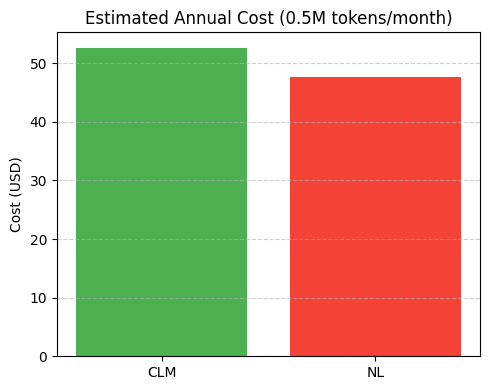

In [13]:
plt.figure(figsize=(5, 4))
plt.bar(["CLM", "NL"], [annual_cost_clm, annual_cost_nl], color=["#4CAF50", "#F44336"])
plt.title("Estimated Annual Cost (0.5M tokens/month)")
plt.ylabel("Cost (USD)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk

nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)


# === Helper functions ===
def get_synonyms(term):
    """Return WordNet synonyms for a given term."""
    if not isinstance(term, str):
        return set()
    synonyms = set()
    for syn in wn.synsets(term):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace("_", " ").lower())
    return synonyms


def semantic_similarity(a, b):
    """Compute semantic similarity between two terms using synonyms + embeddings."""
    if not isinstance(a, str) or not isinstance(b, str):
        return 0.0
    a, b = a.lower(), b.lower()
    if a == b:
        return 1.0
    if b in get_synonyms(a) or a in get_synonyms(b):
        return 0.9

    # TF-IDF embedding similarity
    vectorizer = TfidfVectorizer().fit([a, b])
    vecs = vectorizer.transform([a, b])
    sim = cosine_similarity(vecs[0], vecs[1])[0][0]
    return float(sim)


def similar(a, b, threshold=0.65):
    """Return True if semantic similarity is above threshold."""
    return semantic_similarity(a, b) >= threshold


# === Compute WordNet+Embedding accuracy ===
records = []
for model, modes in data.items():
    clm_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("clm", [])
    }
    nl_records = {
        r["transcript_index"]: parse_llm_output(r.get("llm_output", "{}"))
        for r in modes.get("nl", [])
    }

    for idx in set(clm_records.keys()) & set(nl_records.keys()):
        clm_out, nl_out = clm_records[idx], nl_records[idx]

        issue_clm, issue_nl = clm_out.get("primary_issue"), nl_out.get("primary_issue")
        intent_clm, intent_nl = (
            clm_out.get("customer_intent"),
            nl_out.get("customer_intent"),
        )

        issue_sim = semantic_similarity(issue_clm, issue_nl)
        intent_sim = semantic_similarity(intent_clm, intent_nl)

        # NBA overlap: allow fuzzy matches on IDs/titles
        nba_clm = {
            n.get("nba_id", "").lower()
            for n in clm_out.get("recommended_nbas", [])
            if isinstance(n, dict)
        }
        nba_nl = {
            n.get("nba_id", "").lower()
            for n in nl_out.get("recommended_nbas", [])
            if isinstance(n, dict)
        }

        exact_overlap = len(nba_clm.intersection(nba_nl))
        fuzzy_overlap = sum(1 for n1 in nba_clm for n2 in nba_nl if similar(n1, n2))
        nba_overlap_ratio = min(fuzzy_overlap / max(len(nba_clm), len(nba_nl), 1), 1.0)

        records.append(
            {
                "model": model,
                "transcript_index": idx,
                "primary_issue_sim": issue_sim,
                "customer_intent_sim": intent_sim,
                "nba_overlap_ratio": nba_overlap_ratio,
            }
        )

semantic_df = pd.DataFrame(records)

# === Aggregate ===
semantic_summary2 = (
    semantic_df.groupby("model")
    .agg(
        {
            "primary_issue_sim": "mean",
            "customer_intent_sim": "mean",
            "nba_overlap_ratio": "mean",
        }
    )
    .rename(
        columns={
            "primary_issue_sim": "Primary Issue (semantic sim)",
            "customer_intent_sim": "Customer Intent (semantic sim)",
            "nba_overlap_ratio": "NBA Overlap (semantic sim)",
        }
    )
    .round(3)
)

semantic_summary2["Overall (semantic sim)"] = (
    semantic_summary2["Primary Issue (semantic sim)"] * 0.4
    + semantic_summary2["Customer Intent (semantic sim)"] * 0.4
    + semantic_summary2["NBA Overlap (semantic sim)"] * 0.2
).round(3)

semantic_summary2

,Primary Issue (semantic sim),Customer Intent (semantic sim),NBA Overlap (semantic sim),Overall (semantic sim)
model,,,,
gpt-3.5-turbo,0.3,0.038,0.65,0.265
gpt-4-turbo,0.1,0.135,0.45,0.184
gpt-4-turbo-preview,0.0,0.000,0.00,0.000


<Figure size 800x400 with 0 Axes>

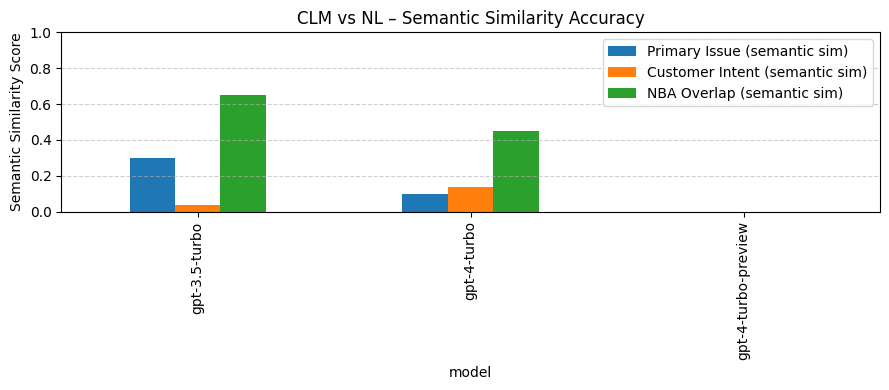

In [17]:
plt.figure(figsize=(8, 4))
semantic_summary2[
    [
        "Primary Issue (semantic sim)",
        "Customer Intent (semantic sim)",
        "NBA Overlap (semantic sim)",
    ]
].plot(kind="bar", figsize=(9, 4), title="CLM vs NL – Semantic Similarity Accuracy")
plt.ylabel("Semantic Similarity Score")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()